In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel2

In [2]:
def circle_data(a, N):
    """
    Calculate coordinates, lengths, angles, and normals for points on a circle.

    Args:
        a (float): Radius of the circle.
        N (int): Number of points to generate.

    Returns:
        numpy.ndarray: Array containing coordinates (x, y), lengths, angles,
                       and normals for each point.
    """
    # xn yn xn+1 yn+1 ln phi_n nx ny
    data = np.zeros((N, 2))
    # Calculate coordinates xn, yn
    for i in range(N):
        xn = a * np.cos((2 * np.pi / N) * (i))
        yn = a * np.sin((2 * np.pi / N) * (i))
        data[i, 0] = xn
        data[i, 1] = yn
    # Duplicate first row at the end for circularity
    circular_data = np.vstack((data[1:], data[0]))
    data = np.hstack((data, circular_data))
    # Calculate ln, phi_n, nx, ny
    ln = np.sqrt((data[:, 2] - data[:, 0])**2 + (data[:, 3] - data[:, 1])**2)
    phi_n = np.arctan2(data[:, 3] - data[:, 1], data[:, 2] - data[:, 0])
    nx = (data[:, 3] - data[:, 1]) / ln
    ny = -(data[:, 2] - data[:, 0]) / ln
    # Concatenate calculated values to data array
    data = np.column_stack((data, ln, phi_n, nx, ny))    
    return data


In [3]:
def Quad(func, a, b):
    # Gauss-Legendre quadrature points and weights
    x = np.array([-9.97263861849481e-01, -9.85611511545268e-01, -9.64762255587506e-01,
                  -9.34906075937740e-01, -8.96321155766052e-01, -8.49367613732570e-01,
                  -7.94483795967942e-01, -7.32182118740290e-01, -6.63044266930215e-01,
                  -5.87715757240762e-01, -5.06899908932229e-01, -4.21351276130635e-01,
                  -3.31868602282128e-01, -2.39287362252137e-01, -1.44471961582796e-01,
                  -4.83076656877383e-02, 4.83076656877382e-02, 1.44471961582797e-01,
                  2.39287362252137e-01, 3.31868602282128e-01, 4.21351276130636e-01,
                  5.06899908932230e-01, 5.87715757240762e-01, 6.63044266930215e-01,
                  7.32182118740289e-01, 7.94483795967942e-01, 8.49367613732570e-01,
                  8.96321155766052e-01, 9.34906075937740e-01, 9.64762255587506e-01,
                  9.85611511545268e-01, 9.97263861849481e-01])
    w = np.array([7.01861000947021e-03, 1.62743947309057e-02, 2.53920653092621e-02,
                  3.42738629130214e-02, 4.28358980222263e-02, 5.09980592623761e-02,
                  5.86840934785358e-02, 6.58222227763622e-02, 7.23457941088488e-02,
                  7.81938957870697e-02, 8.33119242269464e-02, 8.76520930044040e-02,
                  9.11738786957641e-02, 9.38443990808043e-02, 9.56387200792743e-02,
                  9.65400885147275e-02, 9.65400885147285e-02, 9.56387200792748e-02,
                  9.38443990808043e-02, 9.11738786957645e-02, 8.76520930044033e-02,
                  8.33119242269462e-02, 7.81938957870706e-02, 7.23457941088489e-02,
                  6.58222227763618e-02, 5.86840934785352e-02, 5.09980592623760e-02,
                  4.28358980222264e-02, 3.42738629130212e-02, 2.53920653092626e-02,
                  1.62743947309056e-02, 7.01861000946989e-03])

    hm = (b - a) / 2
    hp = (b + a) / 2

    # Evaluate the function at Gauss-Legendre quadrature points
    f = func(hm * x + hp)

    # Compute the integral using Gauss-Legendre quadrature
    I = hm * np.sum(f * w)
    
    return I

In [4]:
def Rmn(l, data, m, n):
    """
    Calculate the distance between an observation point and the midpoint of a segment.

    Args:
        l (float): Distance parameter.
        data (numpy.ndarray): Array containing segment information.
        m (int): Index of the segment.
        n (int): Index of the observation point.

    Returns:
        float: Distance between the observation point and the midpoint of the segment.
    """
    # Extracting data from the input data array
    xn, yn, phi_n = data[n, 0], data[n, 1], data[n, 5]
    xm, ym, lm, phi_m = data[m, 0], data[m, 1], data[m, 4], data[m, 5]

    # Calculating intermediate coordinates
    x = xn + l * np.cos(phi_n)
    y = yn + l * np.sin(phi_n)
    xm_ = xm + 0.5 * lm * np.cos(phi_m)
    ym_ = ym + 0.5 * lm * np.sin(phi_m)

    # Calculating R
    R = np.sqrt((xm_ - x) ** 2 + (ym_ - y) ** 2)

    return R


def Integrand_TM(data, l, m, n, k):
    """
    Calculate the integrand function for TM mode.

    Args:
        data (numpy.ndarray): Array containing segment information.
        l (float): Distance parameter.
        m (int): Index of the segment.
        n (int): Index of the observation point.
        k (float): Wavenumber.

    Returns:
        complex: Value of the integrand.
    """
    R = Rmn(l, data, m, n)
    I = hankel2(0, k * R)
    return I


def calculate_current_distribution(data, phi_i):
    """
    Calculate the current distribution.

    Args:
        data (numpy.ndarray): Array containing segment information.
        phi_i (float): Incident angle in radians.

    Returns:
        numpy.ndarray: Current distribution.
    """
    k = 2 * np.pi  # Wavenumber
    eta0 = 120 * np.pi  # Impedance of free space
    phi_i = np.deg2rad(phi_i)  # Angle of incidence in radians
    N = len(data)  # Number of segments
    Z = np.zeros((N, N), dtype=complex)
    V = np.zeros((N, 1), dtype=complex)

    # Compute the impedance matrix Z
    for i in range(N):
        for ii in range(N):
            ln = data[ii, 4]
            if i == ii:
                func = lambda l: hankel2(0, k * abs(l - ln / 2)) + 1j * (2 / np.pi) * np.log(l / 2)
                Z[i, ii] = (k * eta0 / 4) * (
                    Quad(lambda l: func(l), 0, ln) - 1j * (2 / np.pi) * ln * (np.log(ln / 2) - 1)
                )
            else:
                Z[i, ii] = (k * eta0 / 4) * Quad(lambda l: Integrand_TM(data, l, i, ii, k), 0, ln)

    # Compute the voltage matrix V
    for i in range(N):
        xm = data[i, 0]
        ym = data[i, 1]
        lm = data[i, 4]
        phi_m = data[i, 5]
        xm_ = xm + 0.5 * lm * np.cos(phi_m)
        ym_ = ym + 0.5 * lm * np.sin(phi_m)
        V[i, 0] = np.exp(1j * k * (xm_ * np.cos(phi_i) + ym_ * np.sin(phi_i)))
    # Solve for the current distribution I
    I = np.linalg.solve(Z, V)

    return I

In [5]:
def scattered_field(data, I, xn_grid, yn_grid):
    k = 2 * np.pi  # Wavenumber
    eta0 = 120 * np.pi  # Impedance of free space
    N = len(data)
    e_scat = np.zeros((N, N), dtype=complex)  # Initialize scattered field vector
    for i in range(N):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(N):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            lm = data[j, 4]  # Length of the segment
            phi_m = data[j, 5]  # Angle of the segment
            # Calculate midpoint coordinates
            xm_ = xm + 0.5 * lm * np.cos(phi_m)
            ym_ = ym + 0.5 * lm * np.sin(phi_m)

            r = np.sqrt((xn - xm_)**2 + (yn - ym_)**2)
            e_scat[i] += hankel2(0, k * r) * I[j,0]
    return e_scat

# Calculate the incident field at the grid of points
def incident_field(xn_grid, yn_grid, phi_inc):
    k = 2 * np.pi 
    N = len(xn_grid)

    phi_inc = np.deg2rad(phi_inc)  # Angle of incidence in radians

    e_inc = np.zeros((N, N), dtype=complex)  # Initialize incident field vector
    for i in range(N):
        xn = xn_grid[i]
        yn = yn_grid[i]
        e_inc[i] = np.exp(1j * k * (xn * np.cos(phi_inc) + yn * np.sin(phi_inc)))
    return e_inc     

def sigma(a, N, I):
    phi = np.linspace(0, 2*np.pi, N)
    sigma = 0
    k = 2 * np.pi 
    eta0 = 120 * np.pi  # Impedance of free space
    data = circle_data(a, N)
    for i in range(N):
        xn = data[i, 0]
        yn = data[i, 1]
        ln = data[i, 4]
        phi_n = data[i, 5]
        xn_ = xn + 0.5 * ln * np.cos(phi_n)
        yn_ = yn + 0.5 * ln * np.sin(phi_n)
        sigma += ln * I[i, 0] * np.exp(1j * k * (xn_ * np.cos(phi) + yn_ * np.sin(phi)))

    sigma = (k * eta0**2 / 4) * np.abs(sigma)**2
    RCS_TM = 10*np.log10(sigma)
    return RCS_TM       

In [6]:
a_contour = 3
N = 20*int(2*np.pi*a_contour)
data_contour = circle_data(a_contour, N)
phi_inc = 0
Ns = N
phi = np.linspace(0, np.pi, N)
I = calculate_current_distribution(data_contour, phi_inc)
RCS_TM = sigma(a_contour, N, I)

# Define the grid parameters
x_min, x_max = -15, 15 # Range of x-coordinates
y_min, y_max = -15, 15  # Range of y-coordinates
num_points_x = N  # Number of points along x-axis
num_points_y = N  # Number of points along y-axis

# Create the grid of points
x_grid = np.linspace(x_min, x_max, num_points_x)
y_grid = np.linspace(y_min, y_max, num_points_y)
xn_grid, yn_grid = np.meshgrid(x_grid, y_grid)

e_scat = scattered_field(data_contour, I, xn_grid, yn_grid)
e_inc = incident_field(xn_grid, yn_grid, phi_inc)
# Calculate the total field
e_total = e_inc + e_scat


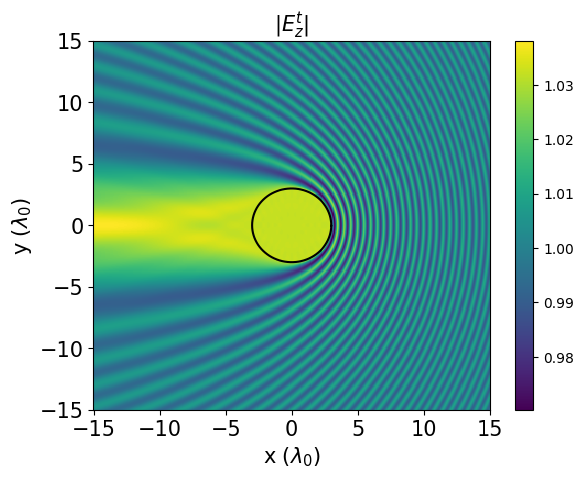

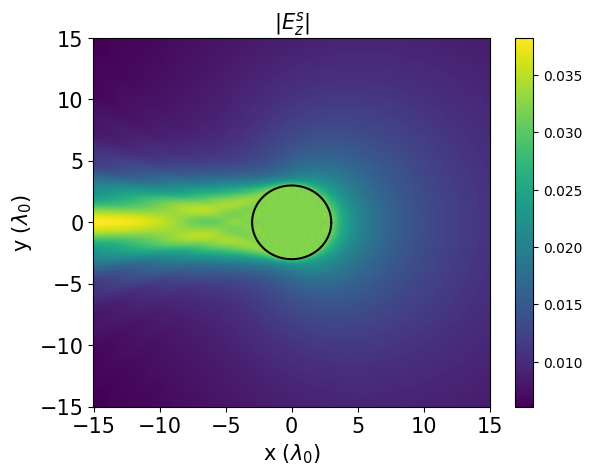

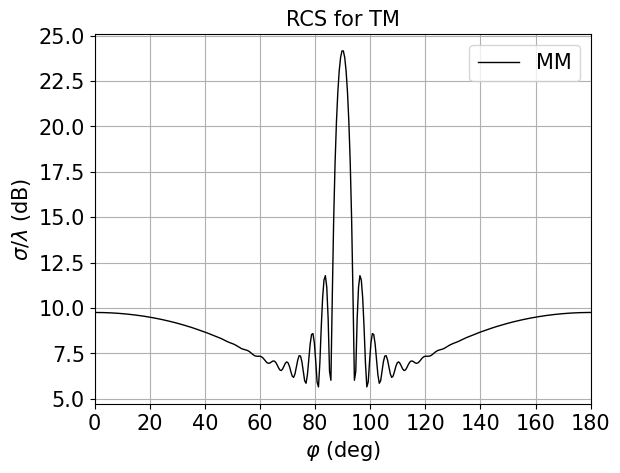

In [7]:
# Plot the total field and the contour of the scatterer
plt.figure()
plt.pcolormesh(xn_grid, yn_grid, np.abs(e_total), shading='auto')
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.plot(data_contour[:, 0], data_contour[:, 1], color='black')  # Plot contour of the scatterer
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Plot the scattered field and the contour of the scatterer
plt.figure()
plt.pcolormesh(xn_grid, yn_grid, np.abs(e_scat), shading='auto')
plt.title(r'|$E^{s}_{z}$|', fontsize=15)
plt.colorbar()
plt.plot(data_contour[:, 0], data_contour[:, 1], color='black')  # Plot contour of the scatterer
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Plot RCS for Method of Moments (MM)
plt.plot(phi * 180 / np.pi, RCS_TM, 'k', linewidth=1, label='MM')
plt.legend(['MM'], loc='upper right', fontsize=15)
plt.xlabel(r'$\varphi$ (deg)', fontsize=15)
plt.ylabel(r'$\sigma/\lambda$ (dB)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('RCS for TM', fontsize=15)
plt.xlim([0, 180])
plt.grid(True)
plt.show()